# Import libraries

In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Import precleaned data

In [3]:
df = pd.read_csv("../data/kununu_cleaned_data.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,employer,record_date,comment,overall_result,interesting_tasks,equality,communication,working_conditions,supervisor_behavior,dealing_w_older_colleagues,colleague_cohesion,environmental_social awareness,salary_benefits,career_training,work_life_balance,image
0,adidas,Mai 2022,adidas AG - Manager Level,not_recommended,4.0,4.0,4.0,4.0,2.0,2.0,4.0,4.0,2.0,2.0,4.0,3.0
1,adidas,Mai 2022,Großer Konzern mit konservativen und veraltete...,not_recommended,1.0,2.0,1.0,3.0,1.0,2.0,1.0,3.0,4.0,1.0,2.0,2.0
2,adidas,Mai 2022,Super Campus aber intern politisch,not_recommended,4.0,1.0,2.0,3.0,2.0,1.0,2.0,4.0,2.0,3.0,5.0,2.0
3,adidas,April 2022,"Große Marke, hohe Erwartungen",recommended,5.0,5.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,2.0,2.0
4,adidas,April 2022,außen hui innen pfui,not_recommended,3.0,2.0,2.0,4.0,2.0,2.0,3.0,3.0,3.0,2.0,3.0,4.0


# Model building
The goal is to build a classification model, that is able to predict weather a employee would recomment a employer based on the different rating features

## Feature selection

In [53]:
# Let's start by encoding the overall result column ("recommended" / "not_recommended"
# to 1s and 0s (binary classification)

encoder = LabelEncoder()
df["overall"] = encoder.fit_transform(df.overall_result)
df.overall_result.value_counts(), df.overall.value_counts()

(recommended        2109
 not_recommended    1065
 Name: overall_result, dtype: int64,
 1    2109
 0    1065
 Name: overall, dtype: int64)

In [57]:
# Split data to data/feature and target 

drop_features = ["employer", "record_date", "comment", "overall_result", "overall"]

target = df.overall
data = df.drop(drop_features, axis=1)

In [56]:
# Check data types
# The features were already encoded (ordinal scaled)
target.info, data.dtypes

(<bound method Series.info of 0       0
 1       0
 2       0
 3       1
 4       0
        ..
 3169    0
 3170    0
 3171    0
 3172    0
 3173    0
 Name: overall, Length: 3174, dtype: int64>,
 interesting_tasks                 float64
 equality                          float64
 communication                     float64
 working_conditions                float64
 supervisor_behavior               float64
 dealing_w_older_colleagues        float64
 colleague_cohesion                float64
 environmental_social awareness    float64
 salary_benefits                   float64
 career_training                   float64
 work_life_balance                 float64
 image                             float64
 dtype: object)

In [58]:
print(f"Number of target samples (rows): {target.shape[0]} \n")
print(f"Number of feature samples (rows): {target.shape[0]} \n")
print(f"Number of features (columns): {data.shape[1]} \n")
print(f"Features:\n {list(data.columns)} \n")

Number of target samples (rows): 3174 

Number of feature samples (rows): 3174 

Number of features (columns): 12 

Features:
 ['interesting_tasks', 'equality', 'communication', 'working_conditions', 'supervisor_behavior', 'dealing_w_older_colleagues', 'colleague_cohesion', 'environmental_social awareness', 'salary_benefits', 'career_training', 'work_life_balance', 'image'] 



In [59]:
# There are still quite a few missing values, 
# which need to be handled (I'll try if these values can be imputed within the model pipeline)

data.isna().sum()

interesting_tasks                 166
equality                          201
communication                     147
working_conditions                169
supervisor_behavior               145
dealing_w_older_colleagues        265
colleague_cohesion                143
environmental_social awareness    250
salary_benefits                   189
career_training                   207
work_life_balance                 203
image                             228
dtype: int64

## Create train-/test split

In [60]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.25, random_state=123)

In [61]:
print(f"Features train set (rows/columns): {data_train.shape}")
print(f"Target train set (rows/columns): {target_train.shape} \n")

print(f"Features test set (rows/columns): {data_test.shape}")

print(f"Target test set (rows/columns): {target_test.shape}")

Features train set (rows/columns): (2380, 12)
Target train set (rows/columns): (2380,) 

Features test set (rows/columns): (794, 12)
Target test set (rows/columns): (794,)


The test set will be left out in the further process until the end for a final evaluation of the model.

## Define preprocessing steps
- impute missing values

In [63]:
# Let's make the model find the numerical columns automatically

numerical_columns_selector = selector(dtype_exclude=object)
numerical_columns = numerical_columns_selector(data)

numerical_columns

['interesting_tasks',
 'equality',
 'communication',
 'working_conditions',
 'supervisor_behavior',
 'dealing_w_older_colleagues',
 'colleague_cohesion',
 'environmental_social awareness',
 'salary_benefits',
 'career_training',
 'work_life_balance',
 'image']

In [70]:
# # Creating a preprocessor pipeline (Column Transformer) like this with only one step is not really necessary here, 
# but getting comfortable with this kind of structure can help later on...

numerical_preprocessor = SimpleImputer(strategy="most_frequent")

preprocessor = make_column_transformer([
    numerical_preprocessor, numerical_columns
], remainder="passthrough")

## Create model pipeline

In [71]:
from sklearn import set_config
set_config(display='diagram')

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['interesting_tasks',
                                                   'equality', 'communication',
                                                   'working_conditions',
                                                   'supervisor_behavior',
                                                   'dealing_w_older_colleagues',
                                                   'colleague_cohesion',
                                                   'environmental_social '
                                                   'awareness',
                                                   'salary_benefits',
                                                   'career_training',
                                                   'work_life_balance',
                                                   'image'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

## Evaluation of the model with cross-validation

In [76]:
scoring = ["accuracy", "balanced_accuracy"]

cv_result = cross_validate(model, data_train, target_train, cv=10, scoring=scoring)
cv_result_df = pd.DataFrame(cv_result)
cv_result_df

,fit_time,score_time,test_accuracy,test_balanced_accuracy
0,0.032055,0.009709,0.903361,0.897171
1,0.029209,0.005067,0.901261,0.885899
2,0.033020,0.005690,0.913866,0.897321
3,0.056957,0.009772,0.907563,0.889420
4,0.018871,0.003404,0.888655,0.864123


In [91]:
print(f"The mean cross-validation accuracy is: {cv_result_df.test_accuracy.mean():.3f} +/- {cv_result_df.test_accuracy.std():.3f}")
print(f"The mean cross-validation balanced accuracy is: {cv_result_df.test_balanced_accuracy.mean():.3f} +/- {cv_result_df.test_balanced_accuracy.std():.3f}")

The mean cross-validation accuracy is: 0.903 +/- 0.009
The mean cross-validation balanced accuracy is: 0.887 +/- 0.014


## Train the model

In [93]:
_ = model.fit(data_train, target_train)

## Predict and score

In [94]:
target_predictions = model.predict(data_test)

In [112]:
score = accuracy_score(target_test, target_predictions)
score2 = balanced_accuracy_score(target_test, target_predictions)
print(f"Accuracy score on test set: {score:.2f}%")
print(f"Accuracy score on test set: {score2:.2f}%")

Accuracy score on test set: 0.89%
Accuracy score on test set: 0.87%


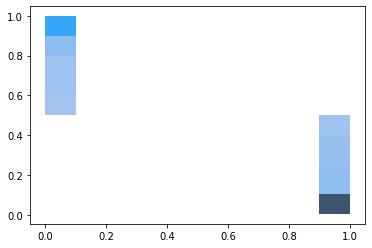

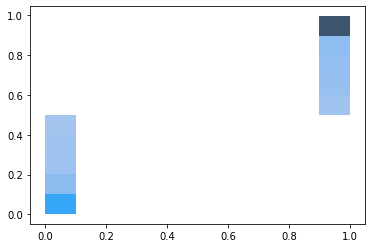

In [156]:
probas = model.predict_proba(data_test)

x_1 = target_predictions[-500:] 
y_1 = probas[-500:,0]
x_0 = target_predictions[-500:] 
y_0 = probas[-500:,1]
_ = sns.histplot(x=x_1, y=y_1)
plt.show()
_ = sns.histplot(x=x_0, y=y_0)
plt.show()

In [131]:
model['logisticregression'].coef_

array([[ 0.17933985,  0.13032365,  0.60771196,  0.19593777,  0.32706629,
         0.08528203,  0.22963624, -0.07874539,  0.28790538,  0.32687987,
         0.22529221,  0.3398163 ]])